# NLP Assignment 1 — Multilingual Word Embeddings



- Dataset preparation (English + French)
- Text preprocessing
- Embedding generation (One-hot, TF-IDF, Word2Vec, FastText)
- Multilingual alignment
- Visualization (PCA and t-SNE)
- Downstream classification task



In [1]:
# Install required libraries
!pip install numpy pandas scikit-learn gensim fasttext matplotlib nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-3.0.2-py3-none-any.whl.metadata (10 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 43.7 MB/s eta 0:00:00
Using cached pybind11-3.0.2-py3-none-any.whl (310 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp312-cp312-linux_x86_64.whl size=4647419 sha256=cb1d5b7c1f6192312dc3242c2f003720f12c23e9d0fa28c96be02d065329e798
  Stored in directory: /root/.cache/pip/wheels/20/27/95/a7baf1b435f1cbde017cabdf1e9688526d2b0e929255a359c6
Successfully built fasttext


## 1. Imports

In [2]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from gensim.models import Word2Vec, FastText
from gensim.utils import simple_preprocess

nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## 2. Dataset Preparation

## 2A. Real Dataset Loading (Tatoeba / OSCAR)

This section shows how to load **real multilingual datasets** using the Hugging Face `datasets` library.






In [3]:
# Install datasets library
!pip install datasets

### Load opus_books (English–French)

In [4]:
from datasets import load_dataset
import pandas as pd

# Load English–French parallel corpus
dataset = load_dataset("opus_books", "en-fr", split="train")



english_sentences = [item["translation"]["en"] for item in dataset]
french_sentences = [item["translation"]["fr"] for item in dataset]

df_en = pd.DataFrame({"text": english_sentences, "lang": "en"})
df_fr = pd.DataFrame({"text": french_sentences, "lang": "fr"})
df = pd.concat([df_en, df_fr]).reset_index(drop=True)

df.head()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

en-fr/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/127085 [00:00<?, ? examples/s]

,text,lang
0,The Wanderer,en
1,Alain-Fournier,en
2,First Part,en
3,I,en
4,THE BOARDER,en


### Text Preprocessing

In [5]:
import re
import unicodedata
from gensim.utils import simple_preprocess

def clean_text(text):
    # Normalize unicode (é → é, ligatures handled consistently)
    text = unicodedata.normalize("NFKC", text)

    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r"http\S+|www\S+", " ", text)

    # Remove HTML tags
    text = re.sub(r"<.*?>", " ", text)

    # Keep letters (latin + accents) and spaces
    text = re.sub(r"[^a-zàâçéèêëîïôûùüÿñæœ\s]", " ", text)

    # Collapse multiple spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

df["clean_text"] = df["text"].astype(str).apply(clean_text)

df["tokens"] = df["clean_text"].apply(
    lambda x: simple_preprocess(x, deacc=False, min_len=2)
)


In [6]:
df

,text,lang,clean_text,tokens
0,The Wanderer,en,the wanderer,"[the, wanderer]"
1,Alain-Fournier,en,alain fournier,"[alain, fournier]"
2,First Part,en,first part,"[first, part]"
3,I,en,i,[]
4,THE BOARDER,en,the boarder,"[the, boarder]"
...,...,...,...,...
254165,"Thérèse prit le verre, le vida à moitié et le ...",fr,thérèse prit le verre le vida à moitié et le t...,"[thérèse, prit, le, verre, le, vida, moitié, e..."
254166,"Ce fut un éclair, Ils tombèrent l'un sur l'aut...",fr,ce fut un éclair ils tombèrent l un sur l autr...,"[ce, fut, un, éclair, ils, tombèrent, un, sur,..."
254167,"La bouche de la jeune femme alla heurter, sur ...",fr,la bouche de la jeune femme alla heurter sur l...,"[la, bouche, de, la, jeune, femme, alla, heurt..."
254168,Les cadavres restèrent toute la nuit sur le ca...,fr,les cadavres restèrent toute la nuit sur le ca...,"[les, cadavres, restèrent, toute, la, nuit, su..."


## 3. Embedding Techniques

In [33]:
import numpy as np

# Create word-level dataset
words = []
labels = []

for tokens, label in zip(df["tokens"], df["lang"]):
    for w in tokens:
        words.append(w)
        labels.append(label)

words = np.array(words)
labels = np.array(labels)

### One-hot Encoding

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

onehot_vectorizer = CountVectorizer(
    binary=True,
    tokenizer=lambda x: [x],   # treat each word as a token
    preprocessor=None,
    token_pattern=None
)

X_onehot = onehot_vectorizer.fit_transform(words)

print(X_onehot.shape)



(5191808, 92274)


### TF-IDF

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    tokenizer=lambda x: [x],
    preprocessor=None,
    token_pattern=None
)

X_tfidf = tfidf_vectorizer.fit_transform(words)

print(X_tfidf.shape)


(5191808, 92274)


### Word2Vec and FastText

In [9]:
def sentence_embedding(tokens, model):
    # Check if model has .wv (Word2Vec / FastText)
    if hasattr(model, "wv"):
        vectors = [model.wv[w] for w in tokens if w in model.wv]
        vector_size = model.vector_size
    else:
        vectors = [model[w] for w in tokens if w in model]
        vector_size = model.vector_size

    if len(vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

In [14]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2026-02-17 18:14:53--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2026-02-17 18:14:53--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2026-02-17 18:14:53--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [15]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

glove_input_file = "glove.6B.100d.txt"
word2vec_output_file = "glove.6B.100d.word2vec.txt"
glove2word2vec(glove_input_file, word2vec_output_file)

glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

# 11. Compute GloVe sentence embeddings
X_glove = np.array([sentence_embedding(t, glove_model) for t in df["tokens"]])

/tmp/ipython-input-61614326.py:6: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


In [10]:
w2v_model = Word2Vec(
    sentences=df["tokens"],
    vector_size=100,
    window=5,
    min_count=1,
    workers=4
)

fasttext_model = FastText(
    sentences=df["tokens"],
    vector_size=100,
    window=5,
    min_count=1,
    workers=4
)



X_w2v = np.array([sentence_embedding(t, w2v_model) for t in df["tokens"]])
X_fasttext = np.array([sentence_embedding(t, fasttext_model) for t in df["tokens"]])

X_w2v.shape, X_fasttext.shape


((254170, 100), (254170, 100))

## 4. Multilingual Alignment

In [11]:
bilingual_dict = {
    # greetings / basic expressions
    "hello": "bonjour",
    "goodbye": "au revoir",
    "thanks": "merci",
    "please": "s'il vous plaît",
    "yes": "oui",
    "no": "non",

    # adjectives
    "good": "bon",
    "bad": "mauvais",
    "big": "grand",
    "small": "petit",
    "new": "nouveau",
    "old": "vieux",
    "happy": "heureux",
    "sad": "triste",

    # nouns (high frequency)
    "bank": "banque",
    "house": "maison",
    "car": "voiture",
    "book": "livre",
    "water": "eau",
    "food": "nourriture",
    "time": "temps",
    "day": "jour",
    "night": "nuit",
    "world": "monde",

    # people
    "man": "homme",
    "woman": "femme",
    "child": "enfant",
    "friend": "ami",

    # verbs (base forms)
    "go": "aller",
    "come": "venir",
    "see": "voir",
    "know": "savoir",
    "want": "vouloir",
    "eat": "manger",
    "drink": "boire",
    "live": "vivre",

    # places
    "city": "ville",
    "country": "pays",
    "school": "école",
    "work": "travail"
}


tokens_en = df[df.lang == "en"]["tokens"]
tokens_fr = df[df.lang == "fr"]["tokens"]

model_en = Word2Vec(tokens_en, vector_size=100, min_count=1)
model_fr = Word2Vec(tokens_fr, vector_size=100, min_count=1)

def get_alignment_matrices(model_en, model_fr, dictionary):
    X, Y, valid_pairs = [], [], []

    for en_word, fr_word in dictionary.items():
        if en_word in model_en.wv and fr_word in model_fr.wv:
            X.append(model_en.wv[en_word])
            Y.append(model_fr.wv[fr_word])
            valid_pairs.append((en_word, fr_word))
        else:
            print(f"Skipped pair (missing vocab): {en_word} ↔ {fr_word}")

    return np.array(X), np.array(Y), valid_pairs


X_align, Y_align, valid_pairs = get_alignment_matrices(
    model_en, model_fr, bilingual_dict
)

# Procrustes alignment
U, _, Vt = np.linalg.svd(X_align.T @ Y_align)
W = U @ Vt
aligned_en = X_align @ W


def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


# Evaluate ONLY valid pairs
for i, pair in enumerate(valid_pairs):
    sim = cosine_similarity(aligned_en[i], Y_align[i])
    print(f"{pair}: cosine similarity = {sim:.3f}")



Skipped pair (missing vocab): goodbye ↔ au revoir
Skipped pair (missing vocab): please ↔ s'il vous plaît
('hello', 'bonjour'): cosine similarity = 0.725
('thanks', 'merci'): cosine similarity = 0.779
('yes', 'oui'): cosine similarity = 0.940
('no', 'non'): cosine similarity = 0.974
('good', 'bon'): cosine similarity = 0.980
('bad', 'mauvais'): cosine similarity = 0.817
('big', 'grand'): cosine similarity = 0.897
('small', 'petit'): cosine similarity = 0.863
('new', 'nouveau'): cosine similarity = 0.776
('old', 'vieux'): cosine similarity = 0.956
('happy', 'heureux'): cosine similarity = 0.959
('sad', 'triste'): cosine similarity = 0.887
('bank', 'banque'): cosine similarity = 0.684
('house', 'maison'): cosine similarity = 0.930
('car', 'voiture'): cosine similarity = 0.672
('book', 'livre'): cosine similarity = 0.870
('water', 'eau'): cosine similarity = 0.962
('food', 'nourriture'): cosine similarity = 0.775
('time', 'temps'): cosine similarity = 0.977
('day', 'jour'): cosine similari

## 5. Visualization

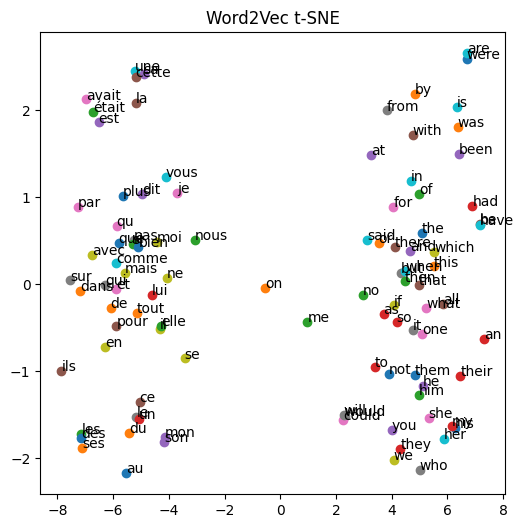

In [12]:
def visualize_embeddings(vectors, labels, title):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(vectors)

    plt.figure(figsize=(6, 6))
    for i, label in enumerate(labels):
        plt.scatter(reduced[i, 0], reduced[i, 1])
        plt.annotate(label, (reduced[i, 0], reduced[i, 1]))

    plt.title(title)
    plt.show()
# Choose more words if available
sample_words = list(w2v_model.wv.index_to_key)[:100]
sample_vectors = np.array([w2v_model.wv[w] for w in sample_words])

# Adaptive perplexity
perplexity = min(30, len(sample_words) - 1)

tsne = TSNE(
    n_components=2,
    perplexity=perplexity,
    random_state=42
)

tsne_vectors = tsne.fit_transform(sample_vectors)

visualize_embeddings(tsne_vectors, sample_words, "Word2Vec t-SNE")



## 6. Downstream Classification Task

In [16]:
y = df["lang"]

def train_classifier(X, name):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)

    print(f"\n=== Results using {name} ===")
    print(classification_report(y_test, preds))

train_classifier(X_onehot, "One-hot")
train_classifier(X_tfidf, "TF-IDF")
train_classifier(X_w2v, "Word2Vec")
train_classifier(X_fasttext, "FastText")
train_classifier(X_glove, "Glove")



=== Results using One-hot ===
              precision    recall  f1-score   support

          en       0.94      0.93      0.93     37929
          fr       0.93      0.94      0.94     38322

    accuracy                           0.93     76251
   macro avg       0.93      0.93      0.93     76251
weighted avg       0.93      0.93      0.93     76251


=== Results using TF-IDF ===
              precision    recall  f1-score   support

          en       0.94      0.94      0.94     37929
          fr       0.94      0.94      0.94     38322

    accuracy                           0.94     76251
   macro avg       0.94      0.94      0.94     76251
weighted avg       0.94      0.94      0.94     76251


=== Results using Word2Vec ===
              precision    recall  f1-score   support

          en       0.93      0.92      0.92     37929
          fr       0.92      0.93      0.92     38322

    accuracy                           0.92     76251
   macro avg       0.92      0.92  

## 6. Analysis and testing

In [18]:
w2v_model.wv.most_similar(
    positive=["king", "woman"],
    negative=["man"],
    topn=10
)

[('duke', 0.8188501596450806),
 ('queen', 0.7893741130828857),
 ('princess', 0.7884945273399353),
 ('bishop', 0.7731696367263794),
 ('governor', 0.7556324601173401),
 ('mayor', 0.7392765879631042),
 ('virgin', 0.7213626503944397),
 ('abbe', 0.7149033546447754),
 ('captain', 0.7125028967857361),
 ('marchesa', 0.6958034038543701)]

In [26]:
print("Synonyms (Word2Vec, EN):")
print("big vs huge:", w2v_model.wv.similarity("big", "huge"))
print("small vs tiny:", w2v_model.wv.similarity("small", "tiny"))
print("happy vs joyful:", w2v_model.wv.similarity("happy", "joyful"))

print("\nAntonyms (Word2Vec, EN):")
print("big vs small:", w2v_model.wv.similarity("big", "small"))
print("happy vs sad:", w2v_model.wv.similarity("happy", "sad"))
print("hot vs cold:", w2v_model.wv.similarity("hot", "cold"))

Synonyms (Word2Vec, EN):
big vs huge: 0.7017647
small vs tiny: 0.8002027
happy vs joyful: 0.30289948

Antonyms (Word2Vec, EN):
big vs small: 0.8104787
happy vs sad: 0.7209028
hot vs cold: 0.82821524


In [27]:
print("Synonyms (fasttext_model, EN):")
print("big vs huge:", fasttext_model.wv.similarity("big", "huge"))
print("small vs tiny:", fasttext_model.wv.similarity("small", "tiny"))
print("happy vs joyful:", fasttext_model.wv.similarity("happy", "joyful"))

print("\nAntonyms (Word2Vec, EN):")
print("big vs small:", fasttext_model.wv.similarity("big", "small"))
print("happy vs sad:", fasttext_model.wv.similarity("happy", "sad"))
print("hot vs cold:", fasttext_model.wv.similarity("hot", "cold"))

Synonyms (fasttext_model, EN):
big vs huge: 0.7017647
small vs tiny: 0.80515164
happy vs joyful: 0.78499514

Antonyms (Word2Vec, EN):
big vs small: 0.6988721
happy vs sad: 0.6793952
hot vs cold: 0.7395463


In [19]:
w2v_model.wv.most_similar("bank", topn=10)

[('bridge', 0.8847622275352478),
 ('path', 0.8707599639892578),
 ('yard', 0.8594326376914978),
 ('platform', 0.8584670424461365),
 ('stage', 0.8559781908988953),
 ('moor', 0.8507071137428284),
 ('shore', 0.8485118746757507),
 ('road', 0.84135502576828),
 ('coast', 0.8361281156539917),
 ('staircase', 0.8350788950920105)]

In [29]:
fasttext_model.wv.most_similar("bank", topn=10)

[('bankrupt', 0.9486781358718872),
 ('bankruptcy', 0.9442253112792969),
 ('banks', 0.9261536598205566),
 ('banjo', 0.9202771186828613),
 ('bridge', 0.9086503982543945),
 ('roadside', 0.9058266282081604),
 ('footbridge', 0.8978974223136902),
 ('road', 0.8941727876663208),
 ('mountebank', 0.8920906186103821),
 ('uxbridge', 0.8919558525085449)]

NameError: name 'nbstripout' is not defined